# Validation tests

Now we apply some geometrical arguments to test if our view of functions as directions in state-space actually holds for this particular dataset. If these tests are successful then we can dive deeper into the data with confidence. First we'll load the packages we need and we'll load the data that we prepared in the previous chapter of the tutorial. 

In [14]:
import pandas as pd                  # general data organisation         
import numpy as np                   # general work with matrices and vectors 
from numpy.linalg import norm, inv   # matrix tools
import matplotlib.pyplot as plt      # general plotting work

# for text formating in figures
plt.rcParams.update({
    "text.usetex": True,
    "font.family": "sans-serif",  
})

# loading the data and saving a colour
grasslands = pd.read_csv("data/grasslands.csv", index_col="Observation")
mismatch_matrix = pd.read_csv("data/mismatch_matrix.csv", index_col="Unnamed: 0")
grass_col = '#b89247'

```{eval-rst}
.. note::

   The matrix of mismatches that we'll use for these validation tests only contains ecosystem functions and not diversity metrics. Gradients of diversity metrics are state-dependent so we can't treat them as fixed directions in state-space across different experiments, which is the approach we take for the ecosystem functions in these validation steps. 
   
.. include:: ./include-rst.rst
```

## Test 1: Linear Combinations

First, we assume that the proportion of mismatches between two functions can be equated to their collinearity:

$$\mathbb{P}(Mismatch)=\frac{\theta}{\pi}$$

where $\theta$ is the angle between the two functions, which we sometimes refer to as their collinearity (or their similarity). In this test we try to predict the collinearity of two given functions using the collinearity of all other pairs of functions.

To gain an intuitive understanding of this test, consider the four functions A-D in the Figure below. This test is asking: if $\theta_{AB}$ is unknown, but we know the other five angles, can we put these functions together like pieces of a jigsaw to reconstruct $\theta_{AB}$? 

:::{figure-md} markdown-fig
<img src="images/linear_combinations.png" alt="linear-combinations" class="bg-primary mb-1" width="60%">

Can the collinearity between functions A and B be reconstructed using the collinearity of all other pairs of functions? 
:::


In the code below we will first define `Cos_data` as the "true" colinearity of functions based on their mismatches with each other. We will then estimate `Cos_hat`, the colinearity of functions based on the collinearity of all other pairs of functions.

In [19]:
# Cos_data, actual collinearity of functions based their proportion of mismatches
Pij=mismatch_matrix.values[:,:]                  
K=len(Pij[0:])
Cos_data=np.zeros([K,K])
for i in range(K):
    for j in range(K):
        Cos_data[i,j]=np.cos(Pij[i,j]*np.pi)     

# Cos_hat, theoretical prediction for the collinearity of functions based on all other collinearities
Norm=np.zeros([K,K]) 
Cos_hat=np.zeros([K,K])  
for i in range(K):
    for j in range(K):
        Cij=np.delete(np.delete(Cos_data,[i,j],0),[i,j],1)
        R=inv(Cij)
        Norm[i,j]=norm(R)
        u=np.delete(Cos_data[i,:],[i,j])
        v=np.delete(Cos_data[j,:],[i,j])
        Cos_hat[i,j]=np.dot(np.dot(R,u),v)
        up=np.delete(Pij[i,:],[i,j])
        vp=np.delete(Pij[j,:],[i,j])
        
cos=np.ravel(Cos_data)    # ground truth
cos_hat=np.ravel(Cos_hat) # prediction
normM=np.ravel(Norm)      # sensitivity

Now we can plot `Cos_data` (ground trut collinearity) against `Cos_hat` (theoretical prediction). 

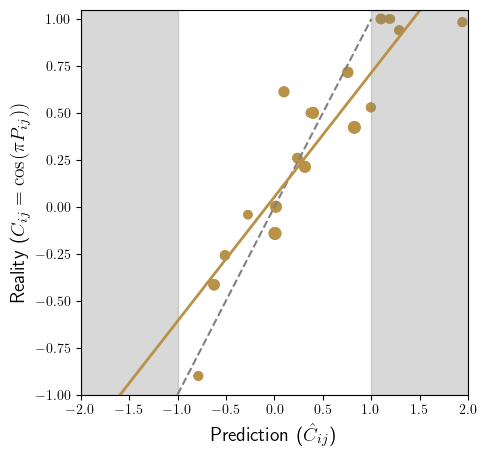

In [20]:
roof=15 # upper bound on sensitivity - if the norm is too high this process won't work

# Plot the prediction against the empirical results (scale points by Norm - larger points with lower norms, more accurate)
plt.figure(num=None, figsize=(5, 5), dpi=100, facecolor='w', edgecolor='k')

plt.scatter(cos_hat[normM<roof],cos[normM<roof],s=500/normM[normM<roof], color = grass_col)
plt.plot([-1,1],[-1,1],'--', color = (0.5, 0.5, 0.5))
plt.fill_between([1,2],[-1,-1],[1.05,1.05],color=(0.5, 0.5, 0.5),alpha=0.3)
plt.fill_between([-2,-1],[-1,-1],[1.05,1.05],color=(0.5, 0.5, 0.5),alpha=0.3)

plt.xlabel('Prediction ($\hat{C}_{ij}$)',fontsize=14)
plt.ylabel('Reality ($C_{ij}=\cos(\pi P_{ij}))$',fontsize=14)
plt.ylim(-1,1.05)
plt.xlim(-2,2)

# linear fit
x=np.concatenate([cos_hat[normM<roof],cos_hat[normM<roof]])
y=np.concatenate([cos[normM<roof],cos[normM<roof]])
lin=np.polyfit(x,y,1)
z=np.linspace(-2,2,100)
plt.plot(z,z*lin[0]+lin[1],'-',lw=2, color = grass_col);

It is very encouraging to see points falling along the 1:1 line. We made quite strong assumptions to reach our theoretical prediction, so results like this give us great confidence that a geometric view of ecosystem functions as directions in state-space is valid. 

::::{important}

This procedure involves a matrix inversion that requires the norm of the matrix not to be too large. This requires that the functions are sufficiently different from one another so that their respective directions do not too closely align. In the figure above we therefore remove predictions that came from matrices with large norms. 

::::

## Test 2: Broadness

In our second test, which is even less likely to produce good predictions than the first test, we ask if the mismatches between two functions can be predicted based on estimates of the broadness of those functions derived from their mismatches with total biomass. 

Let's break that down into two steps: 

1. *Estimate broadness of functions based on their proportion of mismatches with total biomass.* As we know that total biomass is by definition the most broad function (species per-capita contributions are all 1), the general idea is that other broad functions should have low proportions of mimatches with total biomass while narrow functions should have high proportions of mismatches with total biomass.

2. *Use these estimates of broadness to predict collinearity*. Again, two broad functions should have low proportion of mismatches, but two narrow functions would typically have high proportions of mismatches.   


Now we'll apply this logic to obtain `Cos_bio`, or the collinearity of two functions based on their mismatches with biomass. 

In [22]:
# Predicted collinearity based on estimated broadness (which is based on mismatches with biomass)
Prod=np.zeros([K-1,K-1])
for i in range(K-1):
    for j in range(K-1):
        Prod[i,j]=Cos_data[i,-1]*Cos_data[-1,j]      ### -1 refers to the last row and column which is biomass 

#delete these points as they will by definition fall on the 1:1 line
Cos_bio=np.delete(np.delete(Cos_data,K-1,0),K-1,1) 

# norm (again, too high and this won't make sense)
normM_red=np.delete(np.delete(Norm,K-1,0),K-1,1)
roof=15 # upper bound on sensitivity

Finally, we can plot this predicted collinearity, `Cos_bio`, against `Cos_data`

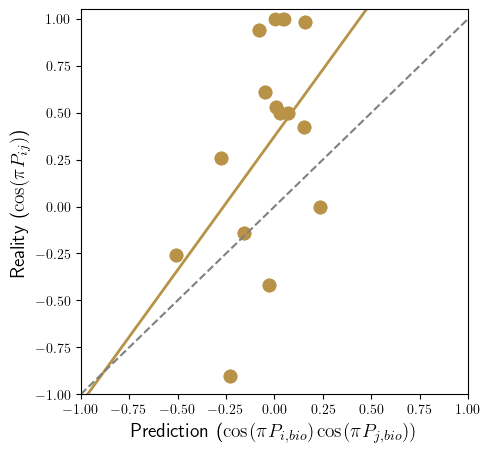

In [23]:
# Plot the prediction against the empirical results
plt.figure(num=None, figsize=(5, 5), dpi=100, facecolor='w', edgecolor='k')

#linear fit
x=np.ravel(Prod[normM_red<roof])
y=np.ravel(Cos_bio[normM_red<roof])
p_all=np.polyfit(x,y,1)
z=np.linspace(-1,1,100)
plt.plot(z,z*p_all[0]+p_all[1],'-',lw=2, color = grass_col)

plt.scatter(Prod[normM_red<roof],Cos_bio[normM_red<roof],s=80, color = grass_col)
plt.xlabel('Prediction ($\cos(\pi P_{i,bio})\cos(\pi P_{j,bio}))$',fontsize=14)
plt.ylabel('Reality ($\cos(\pi P_{ij})$)',fontsize=14)
plt.plot([-1,1],[-1,1],'--', color = (0.5, 0.5, 0.5))
plt.ylim(-1,1.05)
plt.xlim(-1,1);

The results of this test are also very reassuring! We can definitely use our geometric approach for these data. Functions in this grasslands dataset can really be approximated by directions in state space. 

Now we can use our theory to have a deeper dive into the empirical data in the next two chapters.  

## What if your data don't pass these tests?


You may find that running these tests on your own data set doesn't give such clean results. In this case, the first thing to do is to try to increase the consistency of your dataset by focusing on a subset of more similar ecosystem types. Indeed, if we had run these tests on all of the data from the Zhou et al., dataset, rather than on the subset of just grassland experiments, then we wouldn't see points falling along the 1:1 line, instead there would be no correlation between realised and predicted collinearity. 

There is a trade-off between the size and the consistency of your dataset. The more data you have, the more confident you can be with estimates for the proportion of mismatches and the more questions you can ask. However, if those data are from very different systems, assuming that functions have the same directions in state-space across all of those systems becomes unreasonable. 

It is worth pointing out, however, that these two tests are very conservative. Even if the functions in your dataset can actually be represented well by linear directions in state-space, the procedures of these two tests can themselves introduce artefacts leading to noisy results. For example, to obtain the theoretical prediciton in the first test there is a matrix inversion, which only works for functions that are sufficiently different from one another. Furthermore, in the second test, two narrow functions that were involved in the same process (e.g., two enzymes in the nitrogen cycle) would probably have high collinearity, but their predicted collinearity based only on how broad they are would be very low. Therefore, if points don't fall on the 1:1 line in the two tests above, it doesn't necessarily mean that a geometric view of functions isn't valid. However, if points do fall on the 1:1 line, we can certainly be very confident in this approach. 